In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from fcmeans import FCM
import random
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [2]:
data = pd.read_csv("~/ip_timeseries/train_timeseries.csv")

In [3]:
# imamo jedan object: date
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [4]:
# sadrži NaN vrednosti u score
data.isna().any()

fips           False
date           False
PRECTOT        False
PS             False
QV2M           False
T2M            False
T2MDEW         False
T2MWET         False
T2M_MAX        False
T2M_MIN        False
T2M_RANGE      False
TS             False
WS10M          False
WS10M_MAX      False
WS10M_MIN      False
WS10M_RANGE    False
WS50M          False
WS50M_MAX      False
WS50M_MIN      False
WS50M_RANGE    False
score           True
dtype: bool

In [5]:
# izbacujemo sve vrste sa NaN za score
# score se meri samo jednom u nedelju dana
# resetujemo indeks da bi počinjao od 0
data = data[data['score'].notnull()].reset_index(drop=True)
data

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  \
0         1001  2000-01-04    15.95  100.29  6.42  11.40    6.09    6.10   
1         1001  2000-01-11     1.33  100.40  6.63  11.48    7.84    7.84   
2         1001  2000-01-18     1.11  100.39  9.53  14.28   13.26   13.26   
3         1001  2000-01-25     0.00  100.11  2.05  -0.78   -7.93   -7.72   
4         1001  2000-02-01     0.00  101.00  3.36   2.06   -1.73   -1.70   
...        ...         ...      ...     ...   ...    ...     ...     ...   
2756791  56043  2016-11-29     0.04   82.47  2.19  -4.27   -9.36   -9.26   
2756792  56043  2016-12-06     0.13   82.59  0.91 -11.96  -18.65  -17.90   
2756793  56043  2016-12-13     0.02   82.86  1.40  -9.56  -14.18  -13.95   
2756794  56043  2016-12-20     0.32   83.12  2.73  -2.55   -6.90   -6.84   
2756795  56043  2016-12-27     0.16   82.88  1.63  -7.97  -13.49  -12.81   

         T2M_MAX  T2M_MIN  ...     TS  WS10M  WS10M_MAX  WS10M_MIN  \
0          18.09     2.16  ...  11.31   3.84       5.67       2.08   
1          18.88     5.72  ...  10.43   1.76       2.48       1.05   
2          18.04     8.98  ...  14.19   2.63       3.60       1.67   
3           5.65    -5.46  ...  -0.61   3.35       4.59       2.28   
4          11.02    -4.21  ...   1.88   2.03       2.74       0.88   
...          ...      ...  ...    ...    ...        ...        ...   
2756791    -1.51    -7.22  ...  -4.38   6.93      10.27       3.08   
2756792    -6.85   -15.24  ... -11.98   2.27       3.97       0.95   
2756793    -2.69   -13.01  ... -10.95   3.64       6.59       1.28   
2756794     2.66    -7.77  ...  -3.94   6.16       8.43       3.44   
2756795    -1.39   -13.60  ...  -9.41   5.90       7.63       3.61   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0               3.59   6.73       9.31       3.74         5.58    1.0  
1               1.43   3.55       6.38       1.71         4.67    2.0  
2               1.92   5.19       6.40       3.84         2.55    2.0  
3               2.32   5.75       8.03       3.96         4.07    2.0  
4               1.86   4.18       6.38       1.27         5.11    1.0  
...              ...    ...        ...        ...          ...    ...  
2756791         7.18   9.42      12.59       5.62         6.97    0.0  
2756792         3.02   3.07       5.16       0.83         4.33    0.0  
2756793         5.31   5.33       8.35       2.13         6.22    0.0  
2756794         4.99   8.99      10.14       6.67         3.47    0.0  
2756795         4.02   8.58      10.39       5.92         4.47    0.0  

[2756796 rows x 21 columns]

In [6]:
# formatiranje
# formatiranje datuma
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
# i izbacivanje date pošto postaje redundantan
data = data.drop('date', axis = 1).reset_index(drop=True)
# formatiranje score-a
data['score'] = data['score'].round().astype(int)

In [7]:
# feature selection i feature extraction
# T2M_RANGE, WS10M_RANGE i WS50M_RANGE su redundantne i
# mogu da se izbace pošto imamo i max i min za ove vrednosti
data = data.drop('T2M_RANGE', axis = 1)
data = data.drop('WS10M_RANGE', axis = 1)
data = data.drop('WS50M_RANGE', axis = 1)

In [8]:
for i in data.columns:
    if i == 'fips' or i == 'day' or i == 'month' or i == 'year' or i == 'score':
        continue
    data = data[(data[f'{i}'] <= data[f'{i}'].mean() + 3 * data[f'{i}'].std())
              & (data[f'{i}'] >= data[f'{i}'].mean() - 3 * data[f'{i}'].std())]
# provera da li smo dobro izbacili outlier-e
data.shape

(2520551, 20)

In [9]:
# smanjeno obim radi prikaza modela
n = 250000
data_small = data.sample(n)
data_small.shape

(250000, 20)

In [10]:
X = data_small.drop('score', axis = 1)
X = X.drop('fips', axis = 1)
y = data_small['score']

In [11]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data = X_scaled, columns = X.columns)
X

PRECTOT        PS      QV2M       T2M    T2MDEW    T2MWET   T2M_MAX  \
0       0.007925  0.811545  0.132991  0.435207  0.426076  0.415267  0.469427   
1       0.000466  0.818761  0.121325  0.349332  0.404955  0.393072  0.377871   
2       0.022844  0.735569  0.690154  0.724717  0.876117  0.873470  0.685862   
3       0.027040  0.804754  0.140457  0.329791  0.440699  0.428957  0.279359   
4       0.000000  0.670628  0.388707  0.610216  0.696994  0.690521  0.636040   
...          ...       ...       ...       ...       ...       ...       ...   
249995  0.000932  0.315365  0.248250  0.497600  0.547116  0.537440  0.487868   
249996  0.000932  0.807301  0.435838  0.704834  0.741470  0.735947  0.681333   
249997  0.000000  0.806027  0.068129  0.301680  0.294679  0.283344  0.309932   
249998  0.553846  0.609083  0.228185  0.427837  0.546710  0.537026  0.395018   
249999  0.001865  0.648981  0.153990  0.399383  0.447400  0.436217  0.447266   

         T2M_MIN        TS     WS10M  WS10M_MAX  WS10M_MIN     WS50M  \
0       0.417409  0.410011  0.392898   0.557886   0.107527  0.482289   
1       0.326731  0.331119  0.489118   0.457215   0.551971  0.655767   
2       0.774850  0.686052  0.079038   0.085570   0.062724  0.192552   
3       0.394694  0.304228  0.340206   0.467282   0.053763  0.387829   
4       0.589497  0.576381  0.214204   0.204698   0.277778  0.389646   
...          ...       ...       ...        ...        ...       ...   
249995  0.511176  0.483071  0.470790   0.543624   0.211470  0.523161   
249996  0.701436  0.667585  0.171821   0.255034   0.030466  0.189827   
249997  0.335090  0.295642  0.546392   0.558725   0.430108  0.597639   
249998  0.467563  0.406123  0.454754   0.572987   0.322581  0.522252   
249999  0.412139  0.374534  0.736541   0.693792   0.630824  0.812897   

        WS50M_MAX  WS50M_MIN    year     month       day  
0        0.598882   0.088710  0.8125  0.181818  0.366667  
1        0.593990   0.633641  0.1250  0.181818  0.133333  
2        0.283718   0.057604  0.3125  0.454545  0.200000  
3        0.512928   0.051843  0.6250  1.000000  0.666667  
4        0.382949   0.294931  0.6250  0.272727  0.400000  
...           ...        ...     ...       ...       ...  
249995   0.547869   0.262673  0.1250  0.818182  0.233333  
249996   0.336129   0.031106  0.6875  0.636364  0.500000  
249997   0.564640   0.554147  0.5625  1.000000  0.466667  
249998   0.709294   0.358295  0.4375  0.272727  0.300000  
249999   0.728162   0.756912  0.3750  0.181818  0.200000  

[250000 rows x 18 columns]

In [12]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

In [13]:
X_pca.shape

(250000, 2)

In [14]:
#uvode se parametri
k = range(2, 10)
palette = sns.color_palette("blend:#ff0000,#ffff00")

In [15]:
# K-sredina
Kmean_calinski = []
Kmean_davies = []

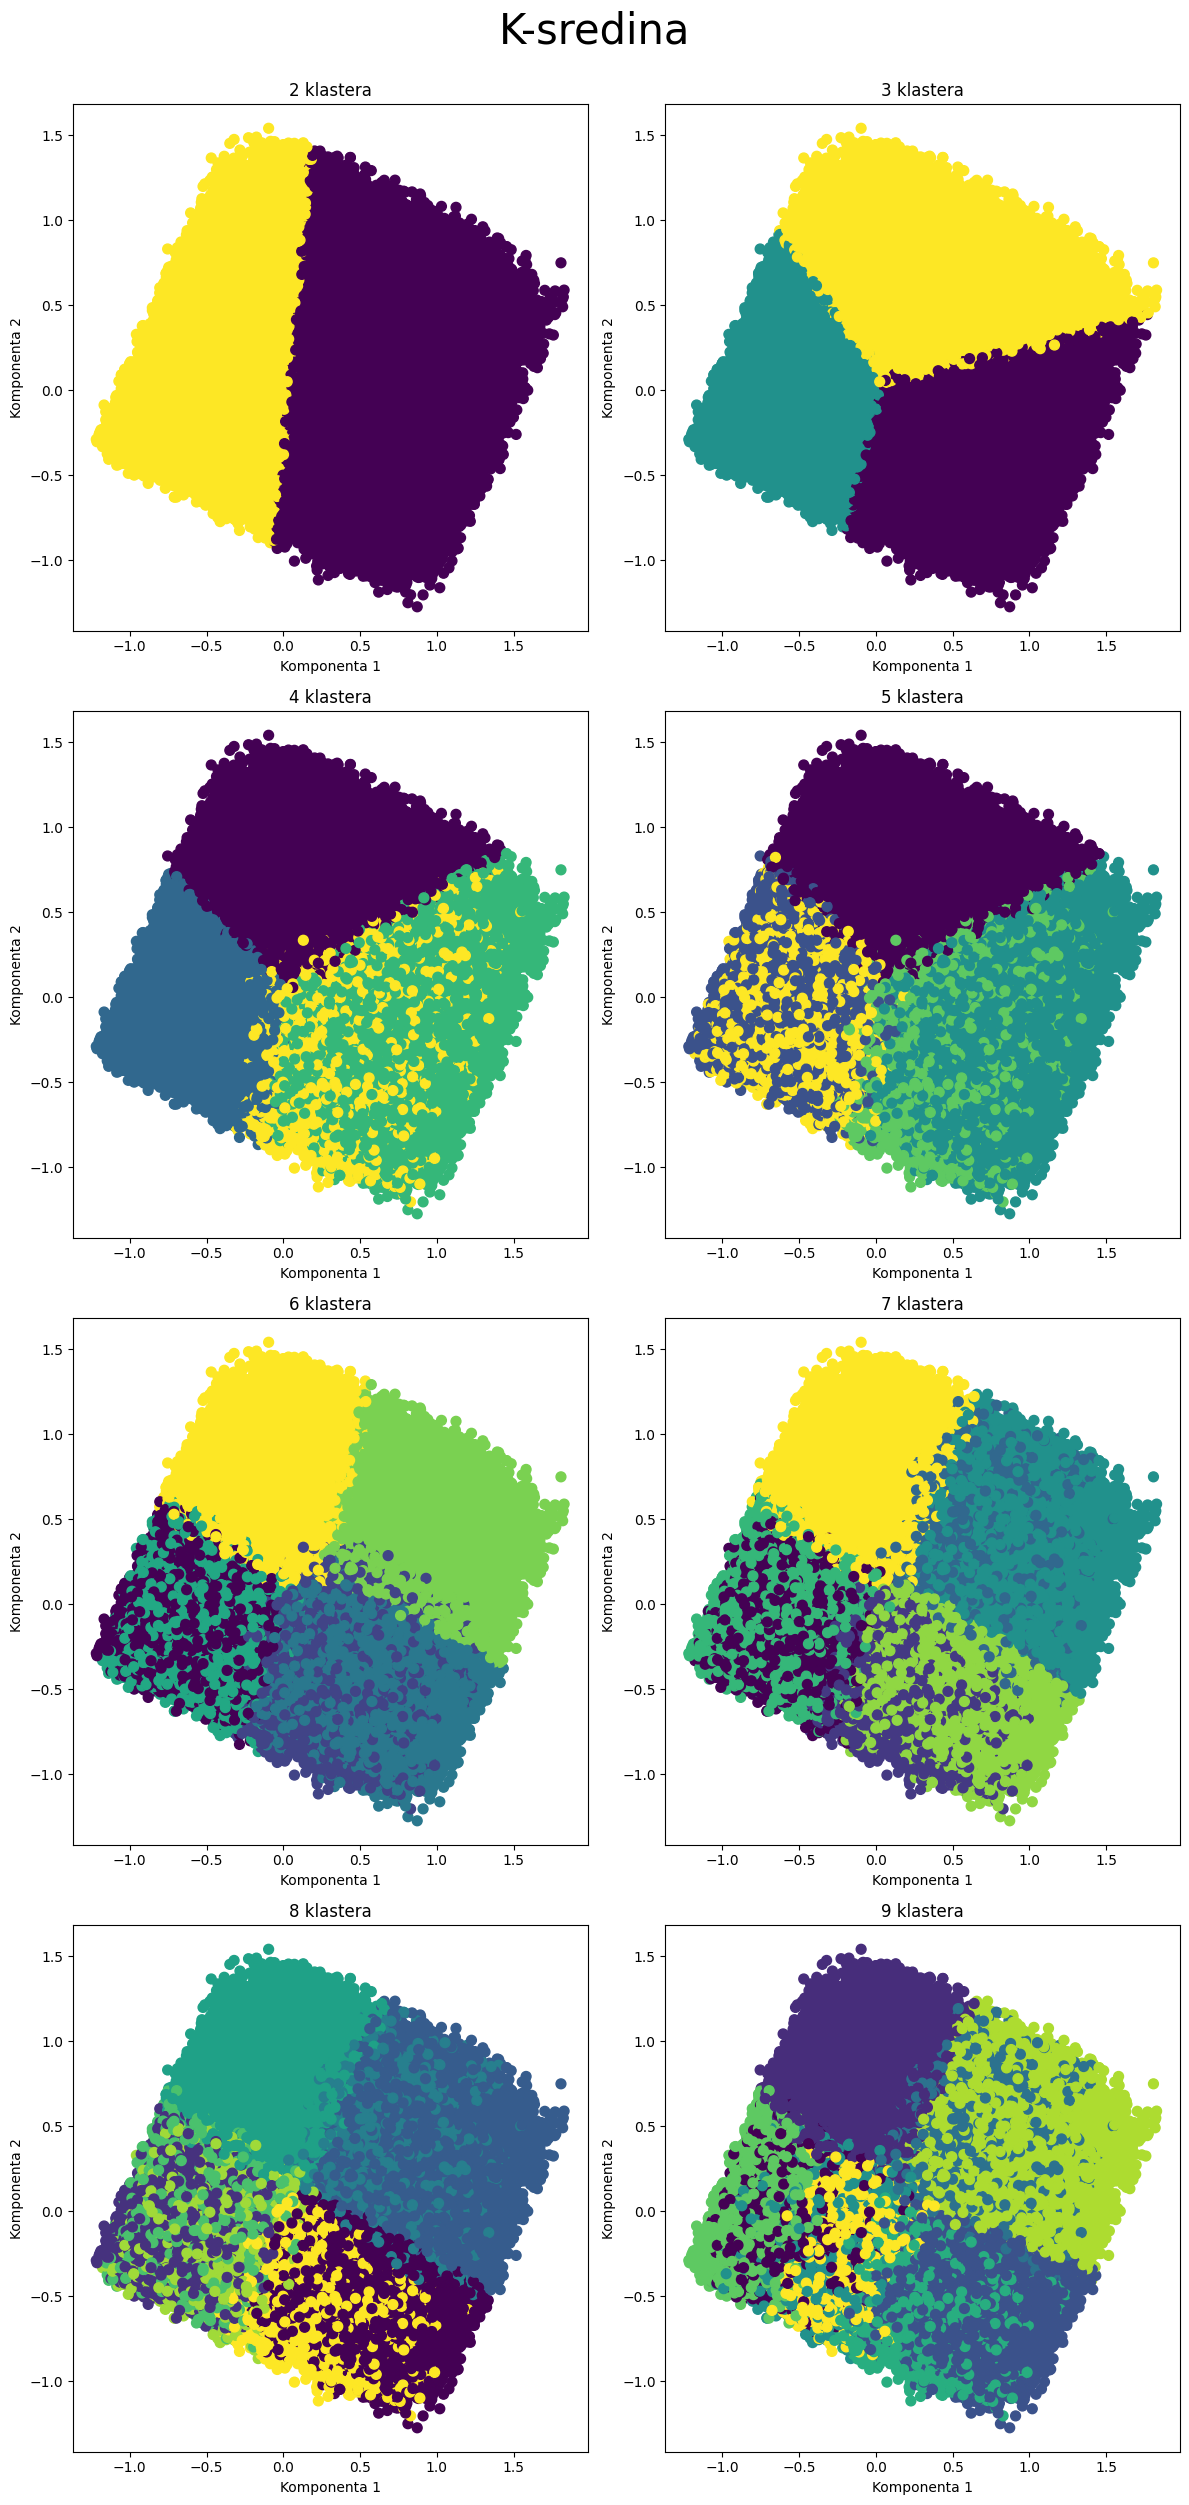

In [16]:
sse = []
silhouettes = []

fig, axs = plt.subplots(4, 2, figsize=(12, 25))
fig.suptitle("K-sredina", y = 1, fontsize = 30)
for i, ax in zip(k, axs.flatten()):
    Kmean = KMeans(n_clusters = i, n_init = 'auto', algorithm='elkan')
    Kmean.fit(X)
    sse.append(Kmean.inertia_)
    silhouettes.append(silhouette_score(X, Kmean.labels_))
    
    Kmean_calinski.append(calinski_harabasz_score(X, Kmean.labels_))
    Kmean_davies.append(davies_bouldin_score(X, Kmean.labels_))
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = Kmean.labels_)
    ax.set_title(f"{i} klastera")
    ax.set_xlabel("Komponenta 1")
    ax.set_ylabel("Komponenta 2")
    
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Skor sse')

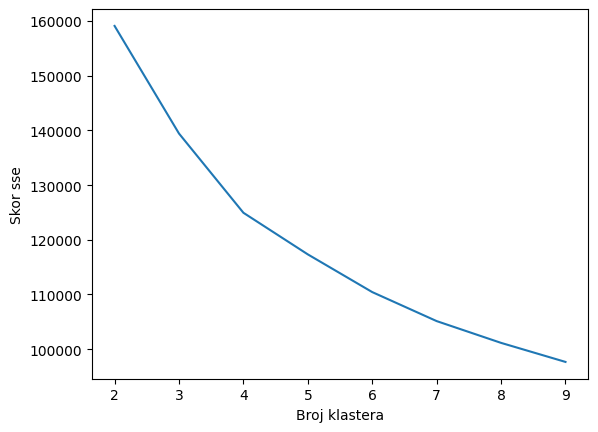

In [17]:
plt.plot(k, sse)
plt.xlabel('Broj klastera')
plt.ylabel('Skor sse')

Text(0, 0.5, 'Skor silueta')

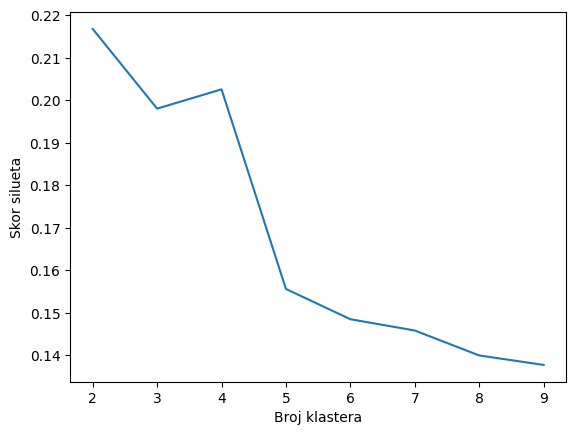

In [18]:
plt.plot(k, silhouettes)
plt.xlabel('Broj klastera')
plt.ylabel('Skor silueta')

In [19]:
# K-sredina sa PCA
Kmean_calinski_pca = []
Kmean_davies_pca = []

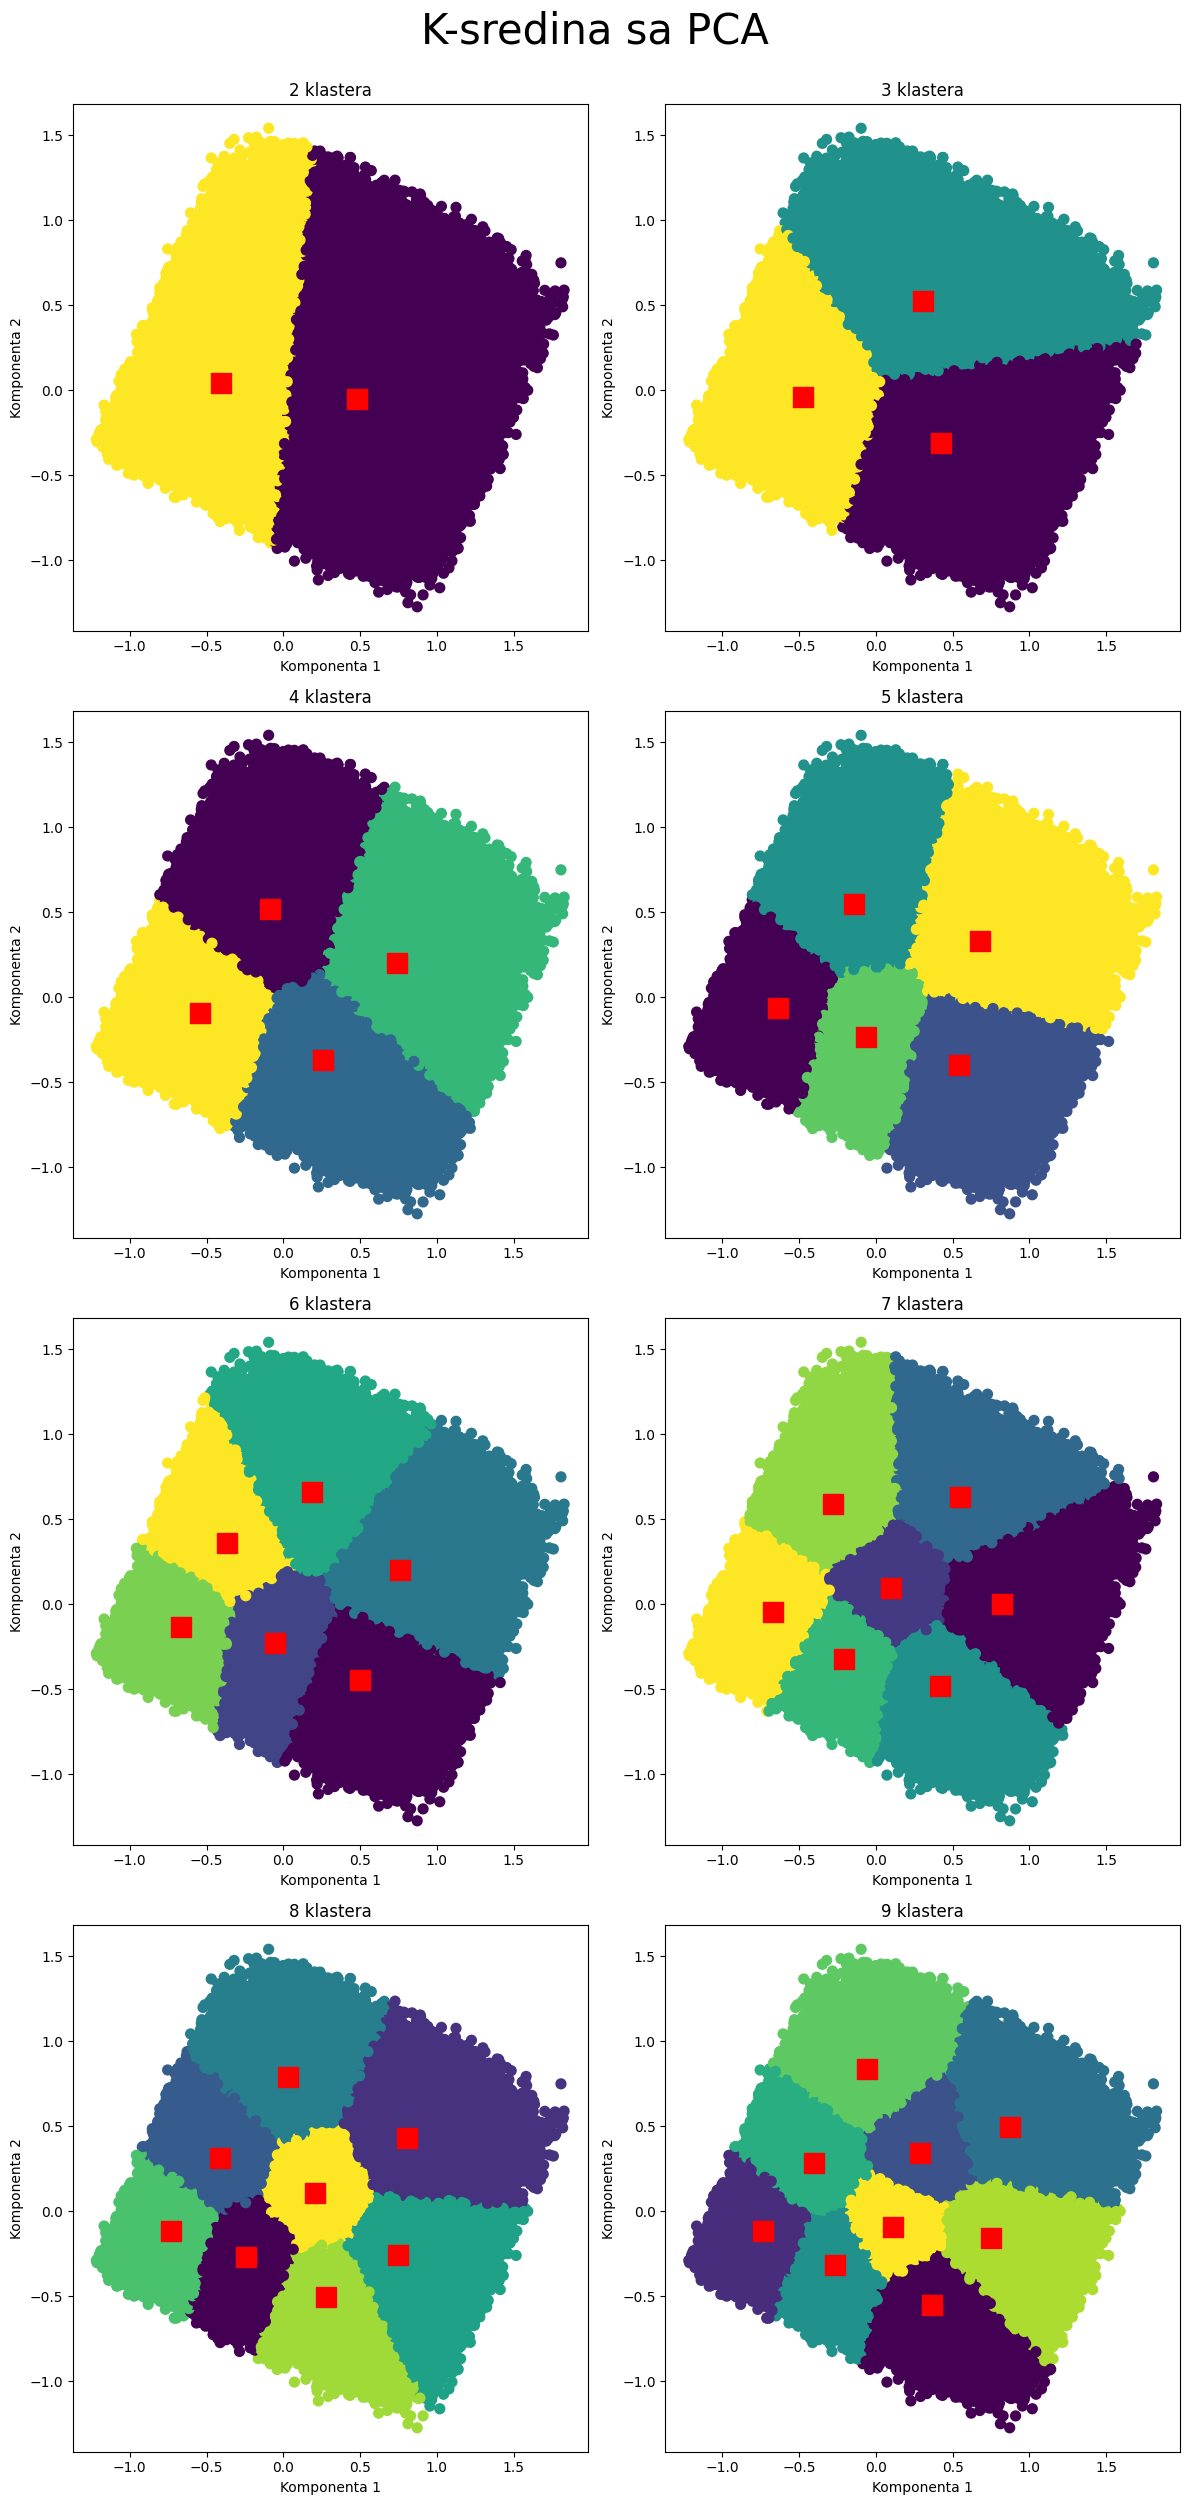

In [20]:
sse_pca = []
silhouettes_pca = []

fig, axs = plt.subplots(4, 2, figsize=(12, 25))
fig.suptitle("K-sredina sa PCA", y = 1, fontsize = 30)
for i, ax in zip(k, axs.flatten()):
    Kmean = KMeans(n_clusters = i, n_init = 'auto', algorithm='elkan')
    Kmean.fit(X_pca)
    sse_pca.append(Kmean.inertia_)
    silhouettes_pca.append(silhouette_score(X_pca, Kmean.labels_))
    
    Kmean_calinski_pca.append(calinski_harabasz_score(X_pca, Kmean.labels_))
    Kmean_davies_pca.append(davies_bouldin_score(X_pca, Kmean.labels_))
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = Kmean.labels_)
    ax.set_title(f"{i} klastera")
    ax.set_xlabel("Komponenta 1")
    ax.set_ylabel("Komponenta 2")
    for j in range (i):
        ax.scatter(Kmean.cluster_centers_[j][0], Kmean.cluster_centers_[j][1], s=200, color=palette[0], marker='s')
        
    if i == 6:
        Kmean_6_pca = Kmean
plt.tight_layout()
plt.show()

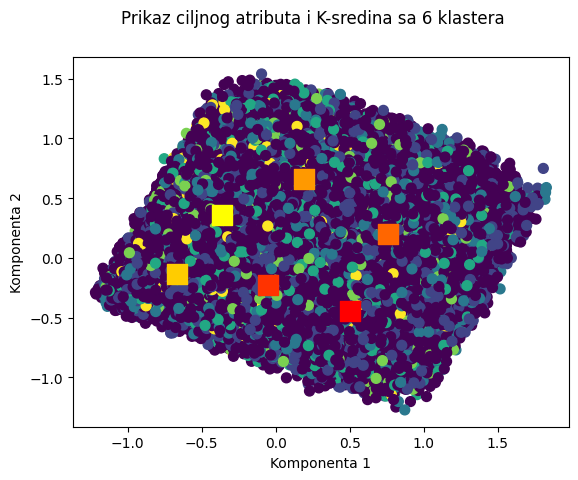

In [21]:
# K-sredina sa PCA nad 6 klastera
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = y)
plt.suptitle("Prikaz ciljnog atributa i K-sredina sa 6 klastera")
plt.xlabel("Komponenta 1")
plt.ylabel("Komponenta 2")
for j in range (6):
    plt.scatter(Kmean_6_pca.cluster_centers_[j][0], Kmean_6_pca.cluster_centers_[j][1], s=200, color=palette[j], marker='s')
plt.show()

Text(0, 0.5, 'Skor sse')

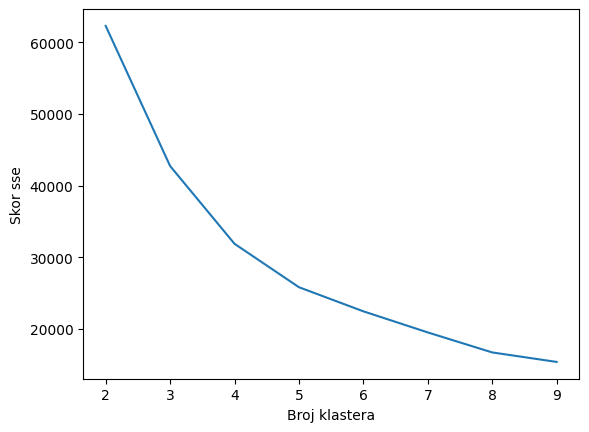

In [22]:
plt.plot(k, sse_pca)
plt.xlabel('Broj klastera')
plt.ylabel('Skor sse')

Text(0, 0.5, 'Skor silueta')

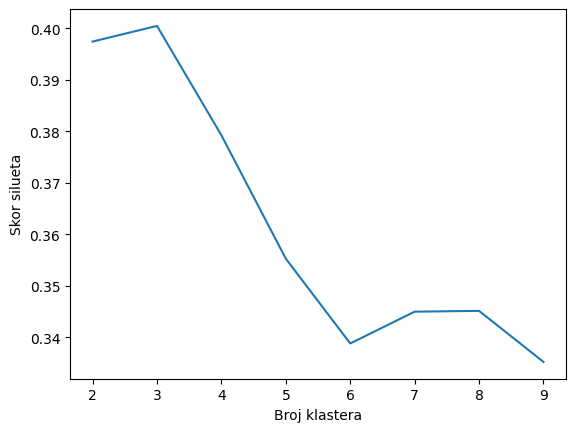

In [23]:
plt.plot(k, silhouettes_pca)
plt.xlabel('Broj klastera')
plt.ylabel('Skor silueta')

In [24]:
# fuzzy c-sredina sa PCA
fcm_calinski_pca = []
fcm_davies_pca = []

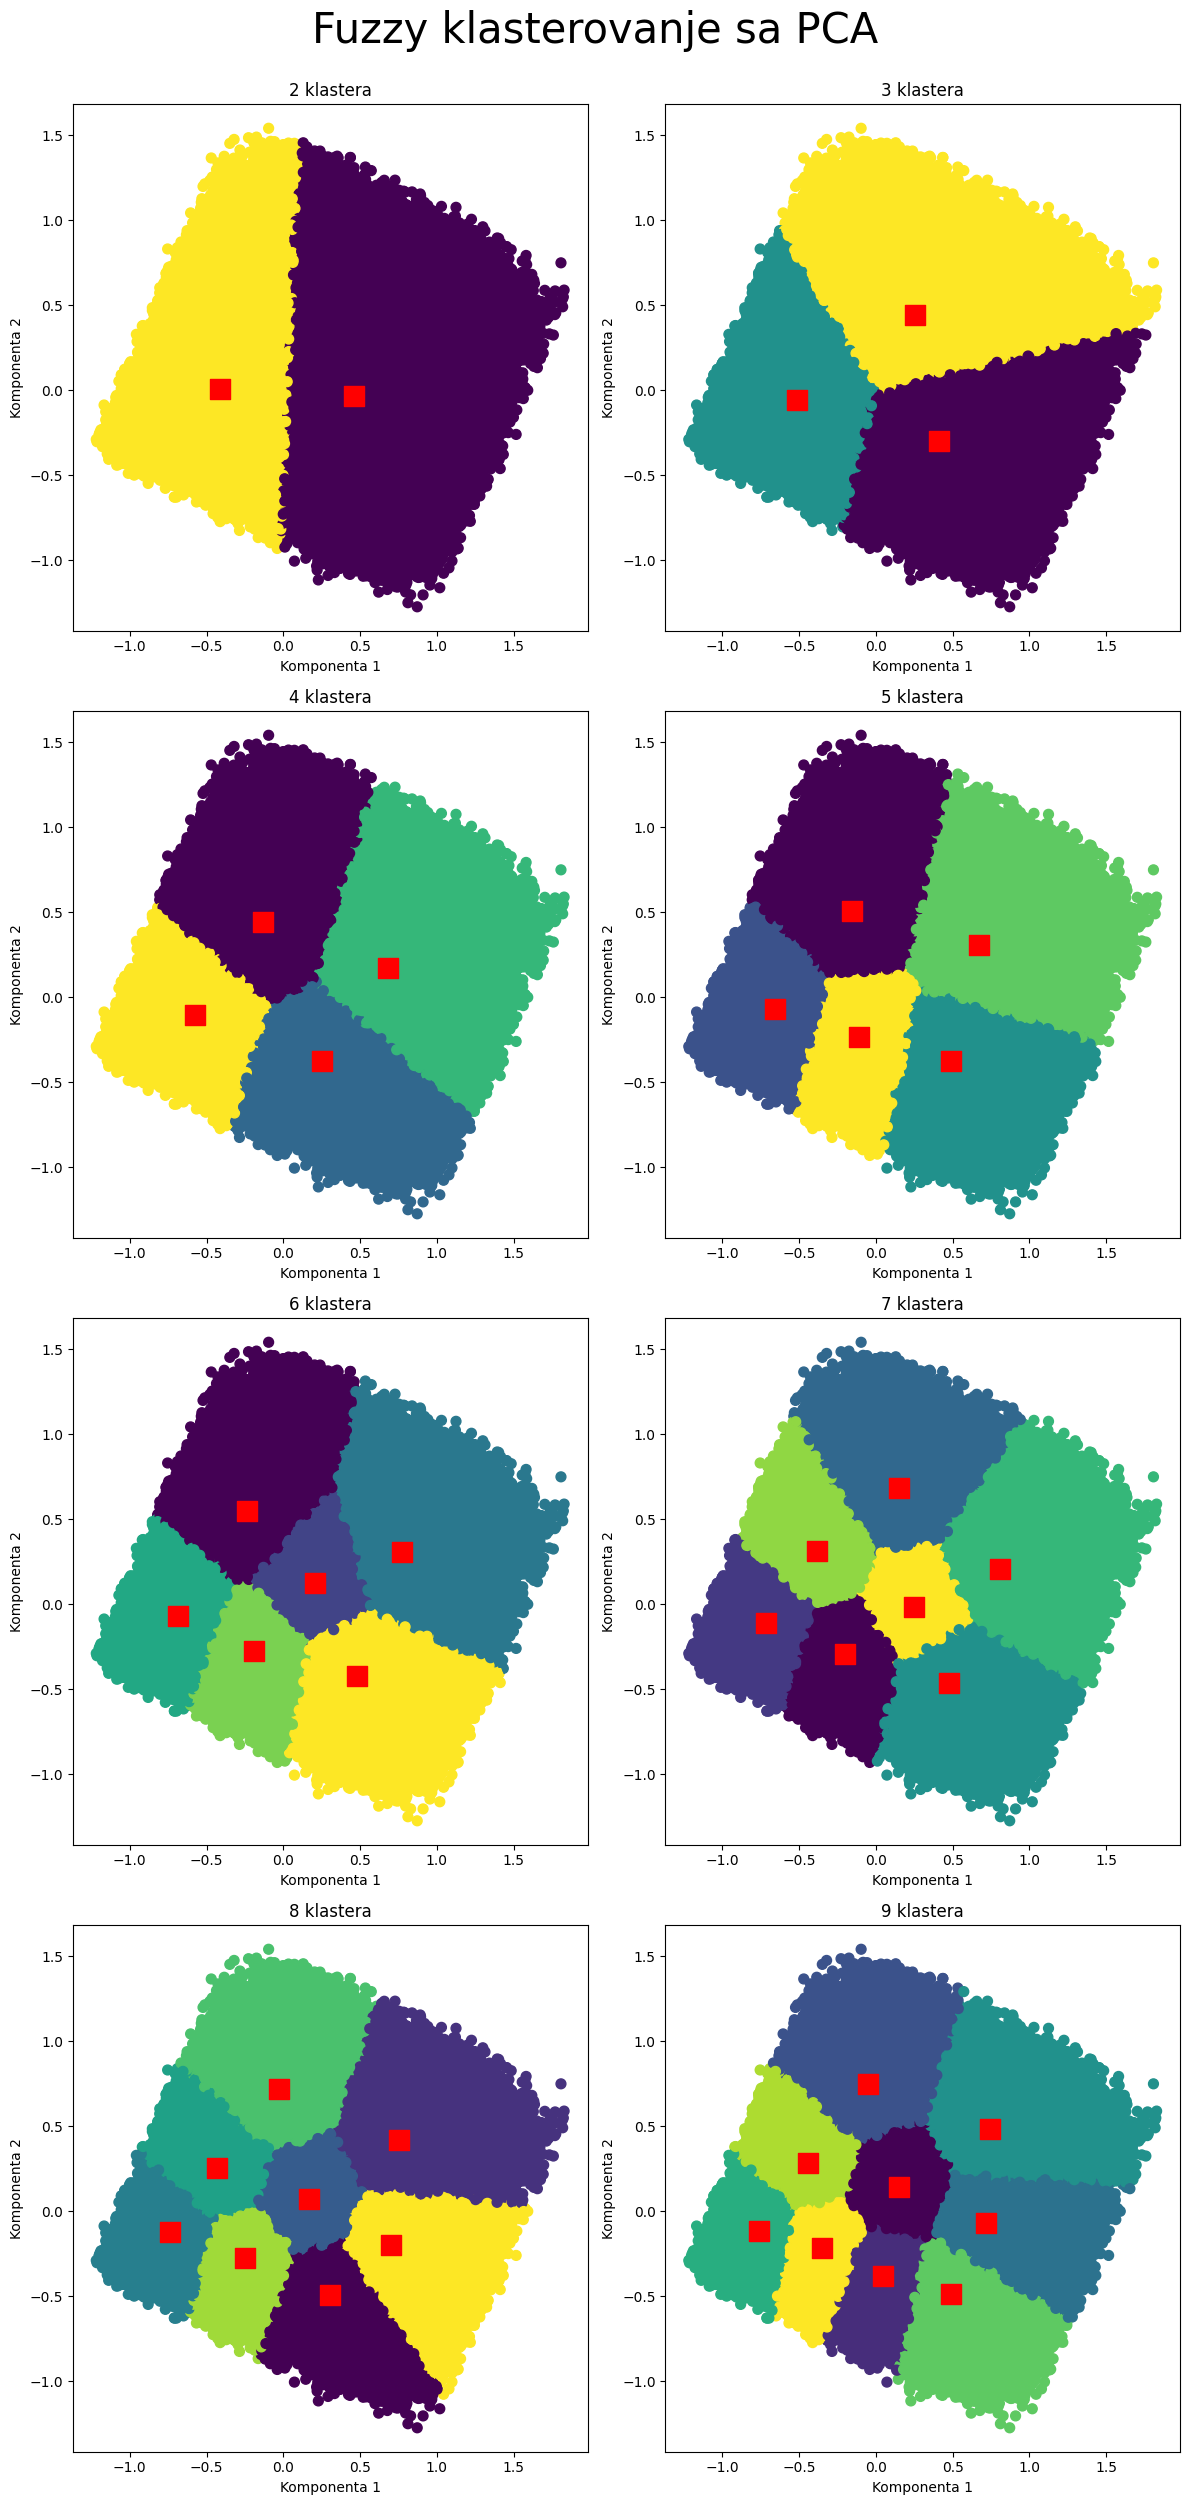

In [25]:
fig, axs = plt.subplots(4, 2, figsize=(12, 25))
fig.suptitle('Fuzzy klasterovanje sa PCA', y = 1, fontsize = 30)
for i, ax in zip(k, axs.flatten()):
    fcm = FCM(n_clusters = i)
    fcm.fit(X_pca)
    
    centers = fcm.centers
    labels = fcm.predict(X_pca)
    
    fcm_calinski_pca.append(calinski_harabasz_score(X_pca, labels))
    fcm_davies_pca.append(davies_bouldin_score(X_pca, labels))
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = labels)
    ax.set_title(f"{i} klastera")
    ax.set_xlabel("Komponenta 1")
    ax.set_ylabel("Komponenta 2")
    for j in range (i):
        ax.scatter(centers[j][0], centers[j][1], s = 200, color = palette[0], marker = 's')
    
    if i == 6:
        centers_6 = centers
plt.tight_layout()
plt.show()

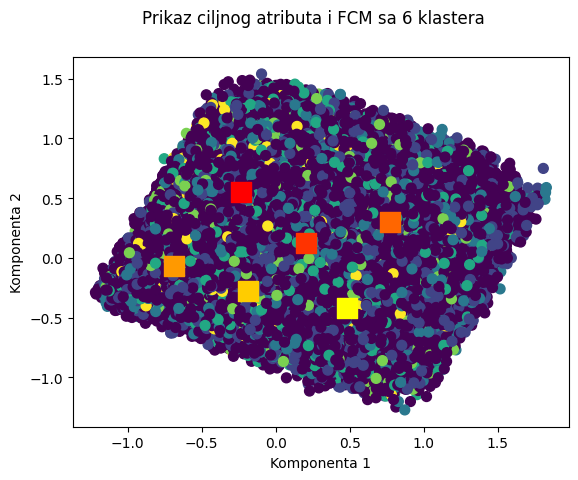

In [26]:
# fcm sa PCA nad 6 klastera
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = y)
plt.suptitle("Prikaz ciljnog atributa i FCM sa 6 klastera")
plt.xlabel("Komponenta 1")
plt.ylabel("Komponenta 2")
for j in range (6):
    plt.scatter(centers_6[j][0], centers_6[j][1], s=200, color=palette[j], marker='s')
plt.show()

In [27]:
# bisektivne k-sredine
BKmean_calinski = []
BKmean_davies = []

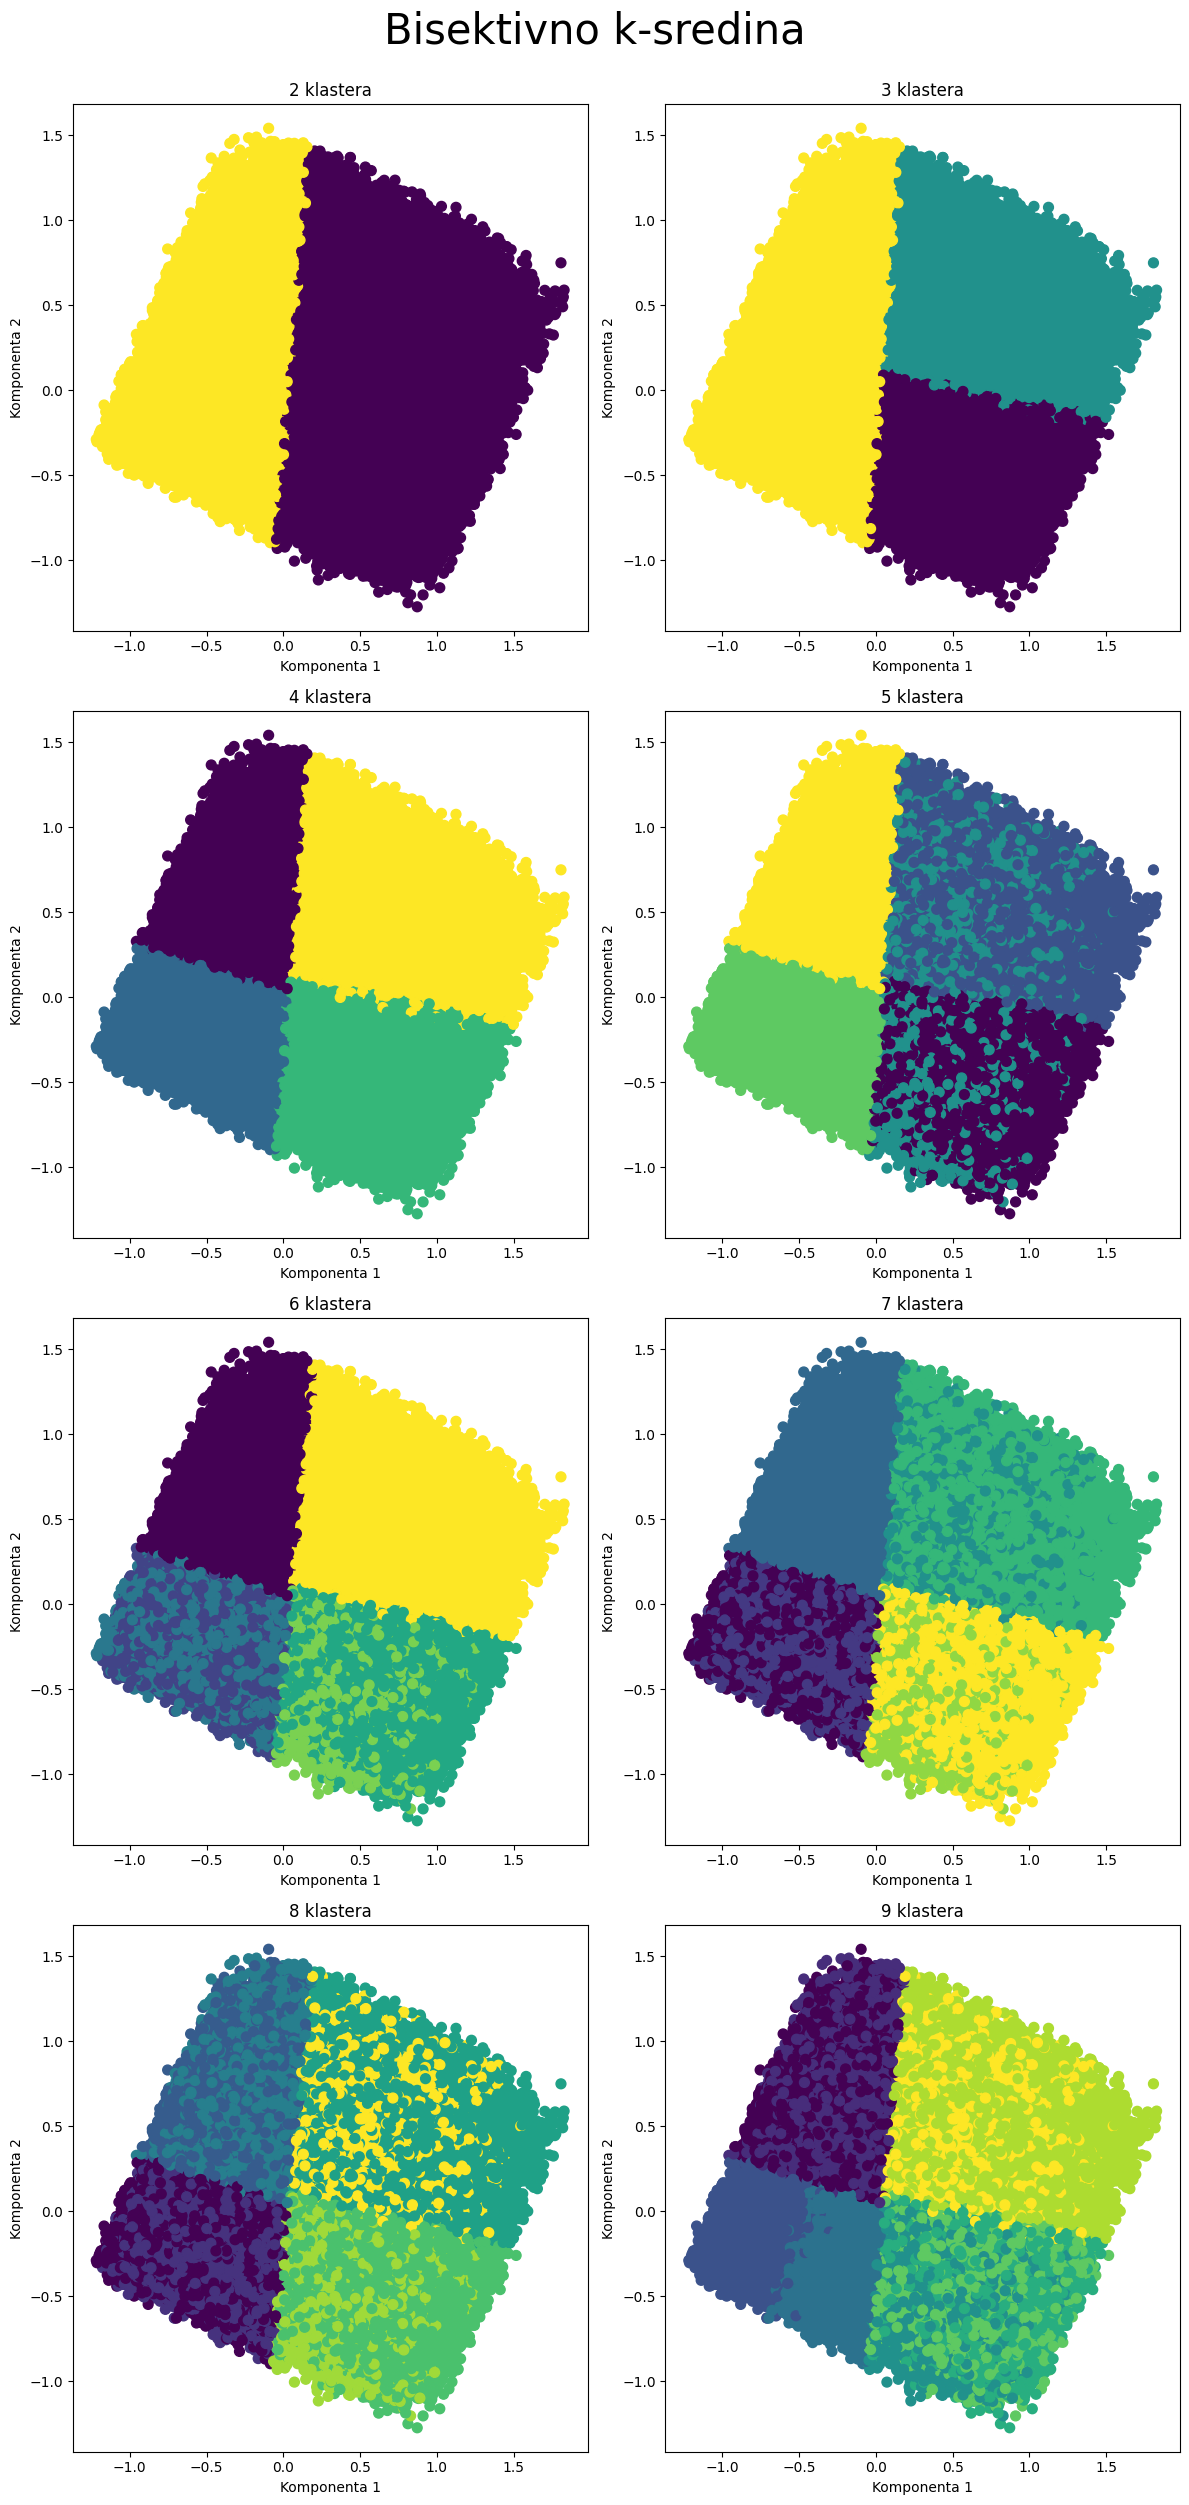

In [28]:
sse_bisecting = []
silhouettes_bisecting = []

fig, axs = plt.subplots(4, 2, figsize=(12, 25))
fig.suptitle("Bisektivno k-sredina", y = 1, fontsize = 30)
for i, ax in zip(k, axs.flatten()):
    BKmean = BisectingKMeans(n_clusters = i, algorithm = 'elkan')
    BKmean.fit(X)
    sse_bisecting.append(BKmean.inertia_)
    silhouettes_bisecting.append(silhouette_score(X, BKmean.labels_))
    
    BKmean_calinski.append(calinski_harabasz_score(X, BKmean.labels_))
    BKmean_davies.append(davies_bouldin_score(X, BKmean.labels_))
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = BKmean.labels_)
    ax.set_title(f"{i} klastera")
    ax.set_xlabel("Komponenta 1")
    ax.set_ylabel("Komponenta 2")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Skor sse')

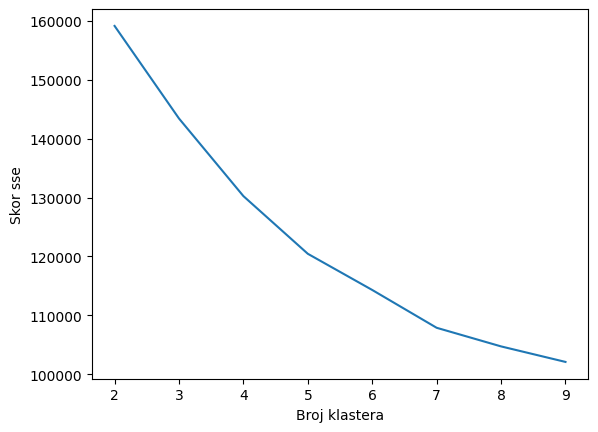

In [29]:
plt.plot(k, sse_bisecting)
plt.xlabel('Broj klastera')
plt.ylabel('Skor sse')

Text(0, 0.5, 'Skor silueta')

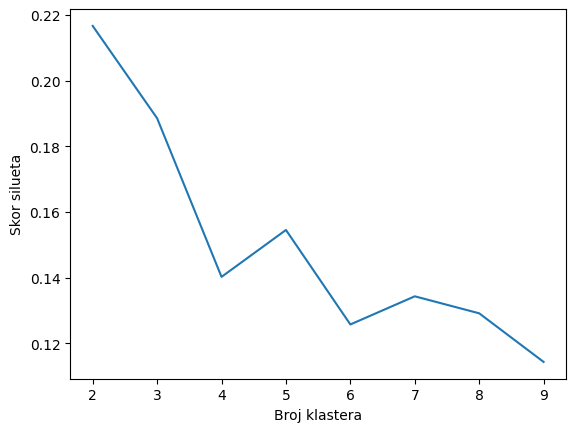

In [30]:
plt.plot(k, silhouettes_bisecting)
plt.xlabel('Broj klastera')
plt.ylabel('Skor silueta')

In [31]:
# bisektivne k-sredine sa PCA
BKmean_calinski_pca = []
BKmean_davies_pca = []

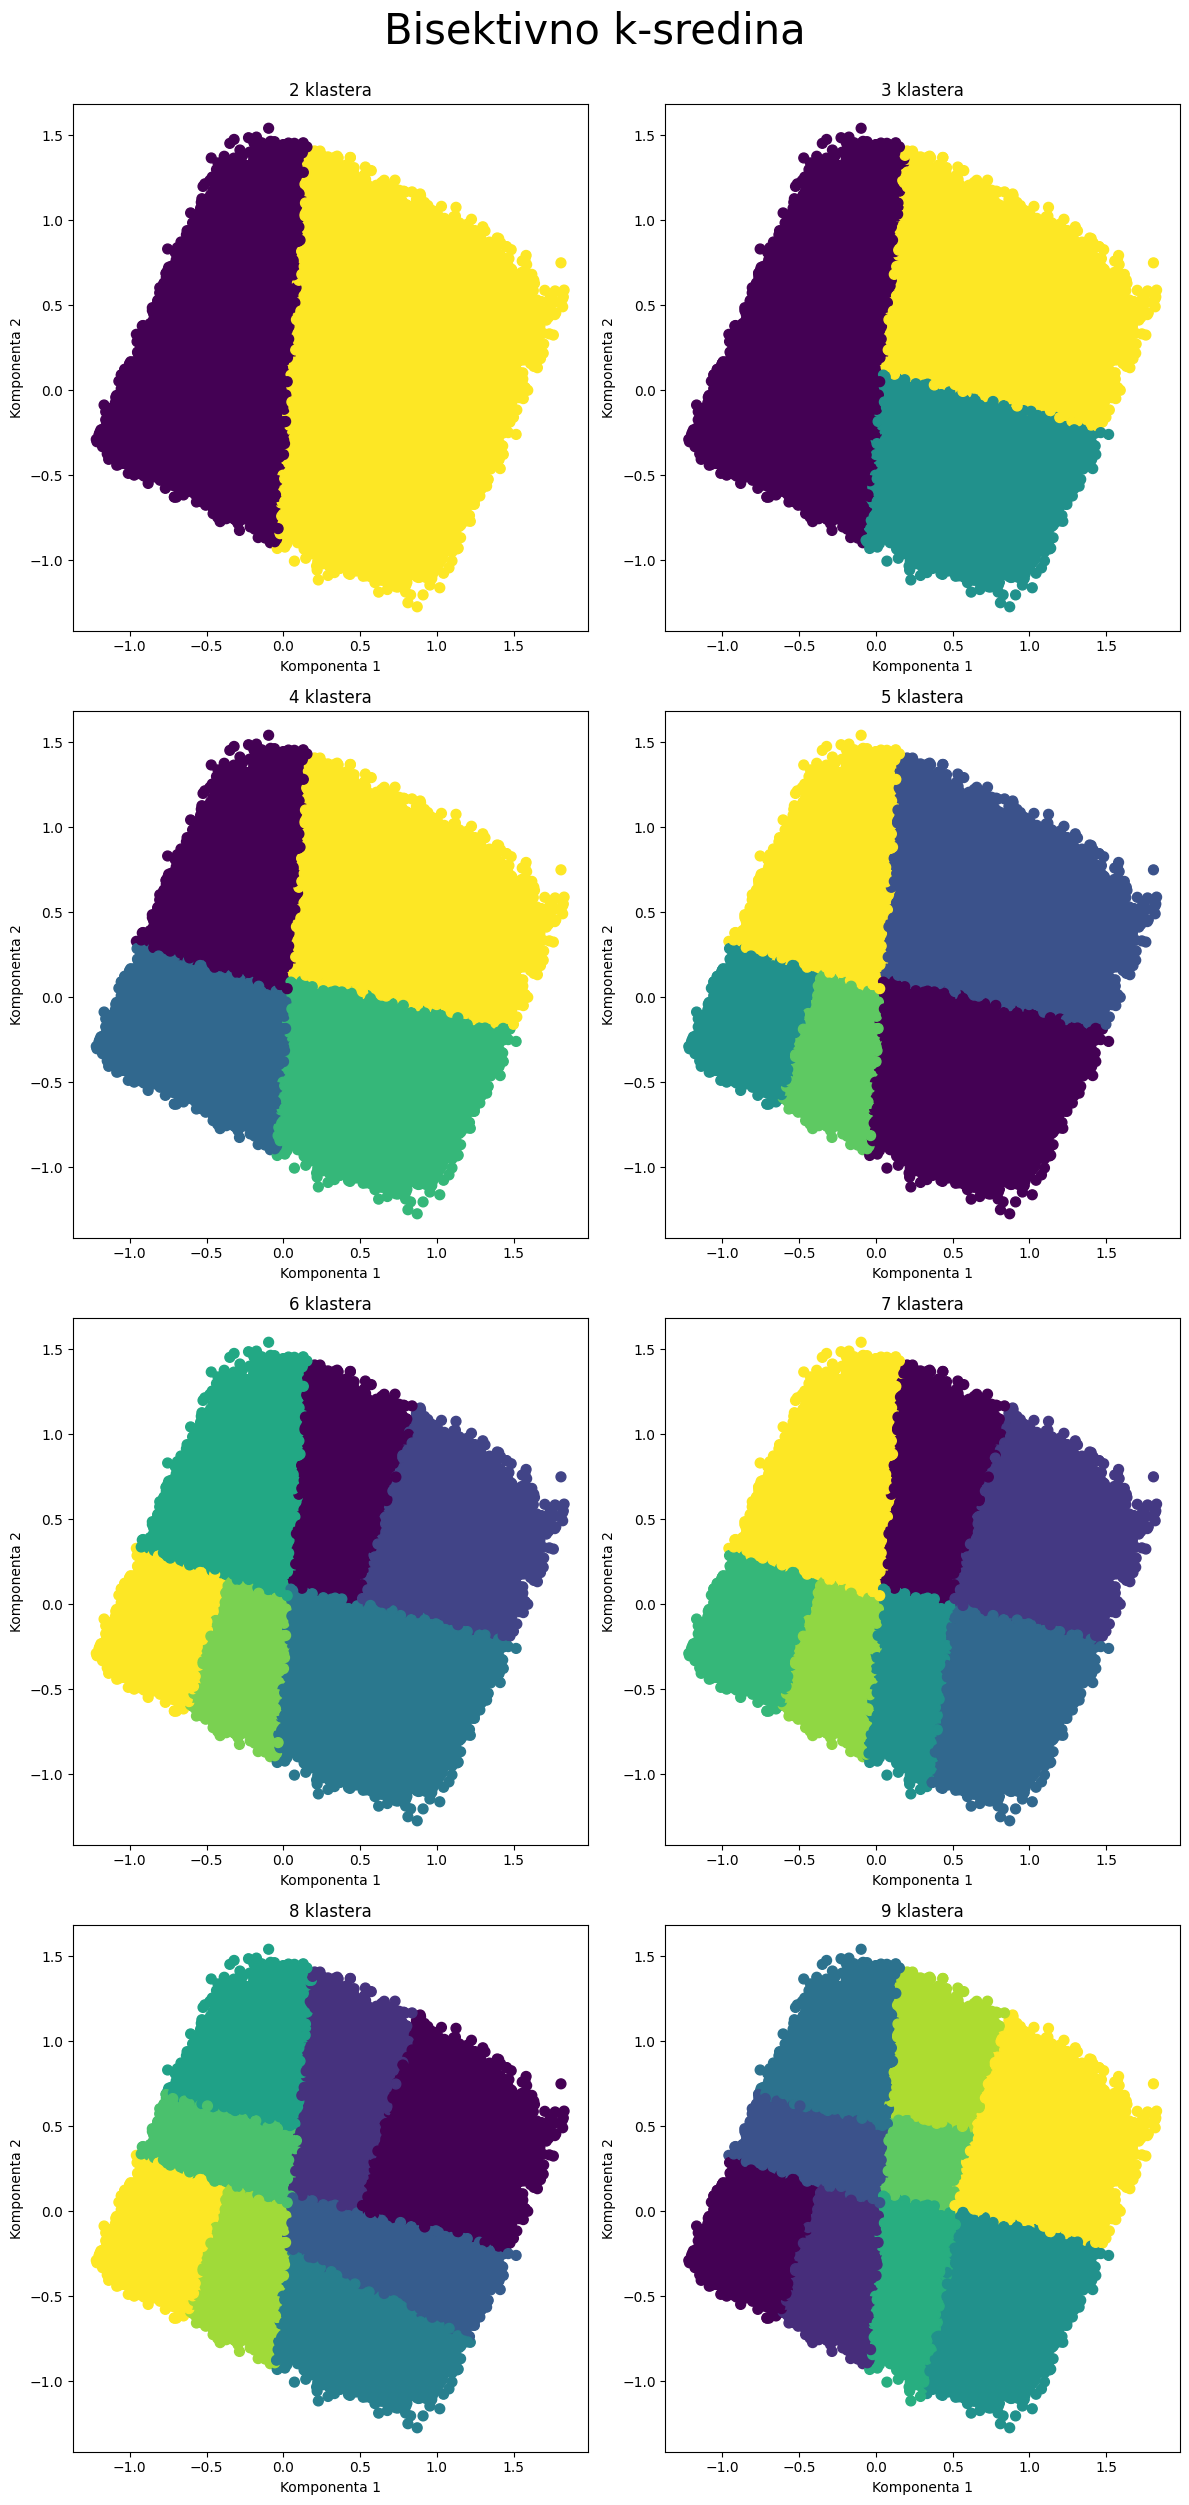

In [32]:
sse_bisecting_pca = []
silhouettes_bisecting_pca = []

fig, axs = plt.subplots(4, 2, figsize=(12, 25))
fig.suptitle("Bisektivno k-sredina", y = 1, fontsize = 30)
for i, ax in zip(k, axs.flatten()):
    BKmean = BisectingKMeans(n_clusters = i, algorithm = 'elkan')
    BKmean.fit(X_pca)
    sse_bisecting_pca.append(BKmean.inertia_)
    silhouettes_bisecting_pca.append(silhouette_score(X_pca, BKmean.labels_))
    
    BKmean_calinski_pca.append(calinski_harabasz_score(X_pca, BKmean.labels_))
    BKmean_davies_pca.append(davies_bouldin_score(X_pca, BKmean.labels_))
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = BKmean.labels_)
    ax.set_title(f"{i} klastera")
    ax.set_xlabel("Komponenta 1")
    ax.set_ylabel("Komponenta 2")
    
    if i == 6:
        BKmean_6 = BKmean
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Skor sse')

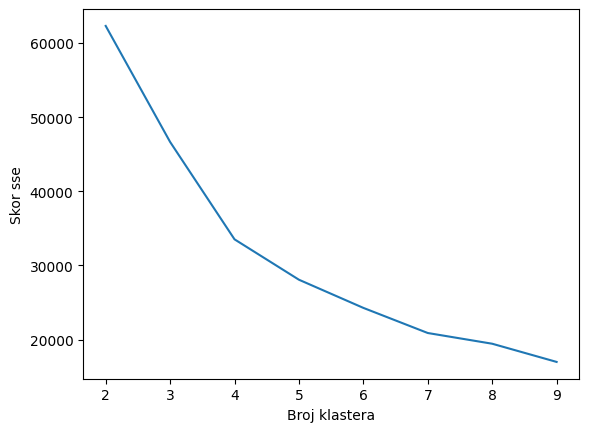

In [33]:
plt.plot(k, sse_bisecting_pca)
plt.xlabel('Broj klastera')
plt.ylabel('Skor sse')

Text(0, 0.5, 'Skor silueta')

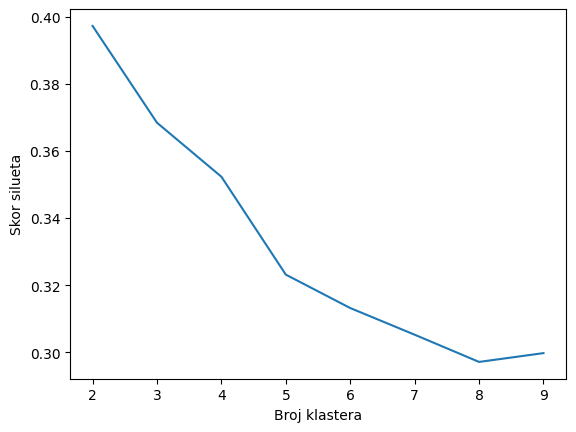

In [34]:
plt.plot(k, silhouettes_bisecting_pca)
plt.xlabel('Broj klastera')
plt.ylabel('Skor silueta')

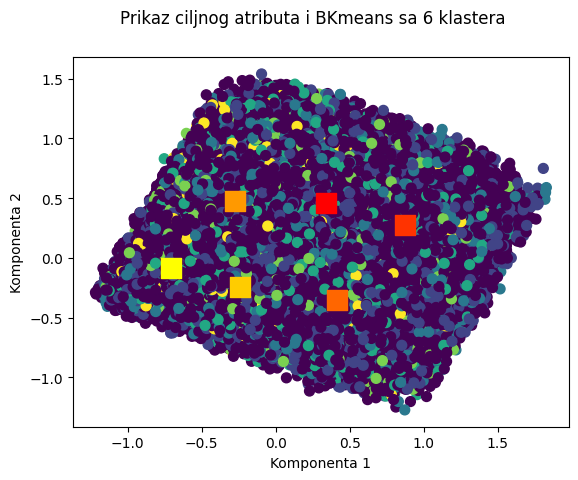

In [35]:
# bisektivne k-sredine sa PCA nad 6 klastera
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 50, c = y)
plt.suptitle("Prikaz ciljnog atributa i BKmeans sa 6 klastera")
plt.xlabel("Komponenta 1")
plt.ylabel("Komponenta 2")
for j in range (6):
    plt.scatter(BKmean_6.cluster_centers_[j][0], BKmean_6.cluster_centers_[j][1], s=200, color=palette[j], marker='s')
plt.show()

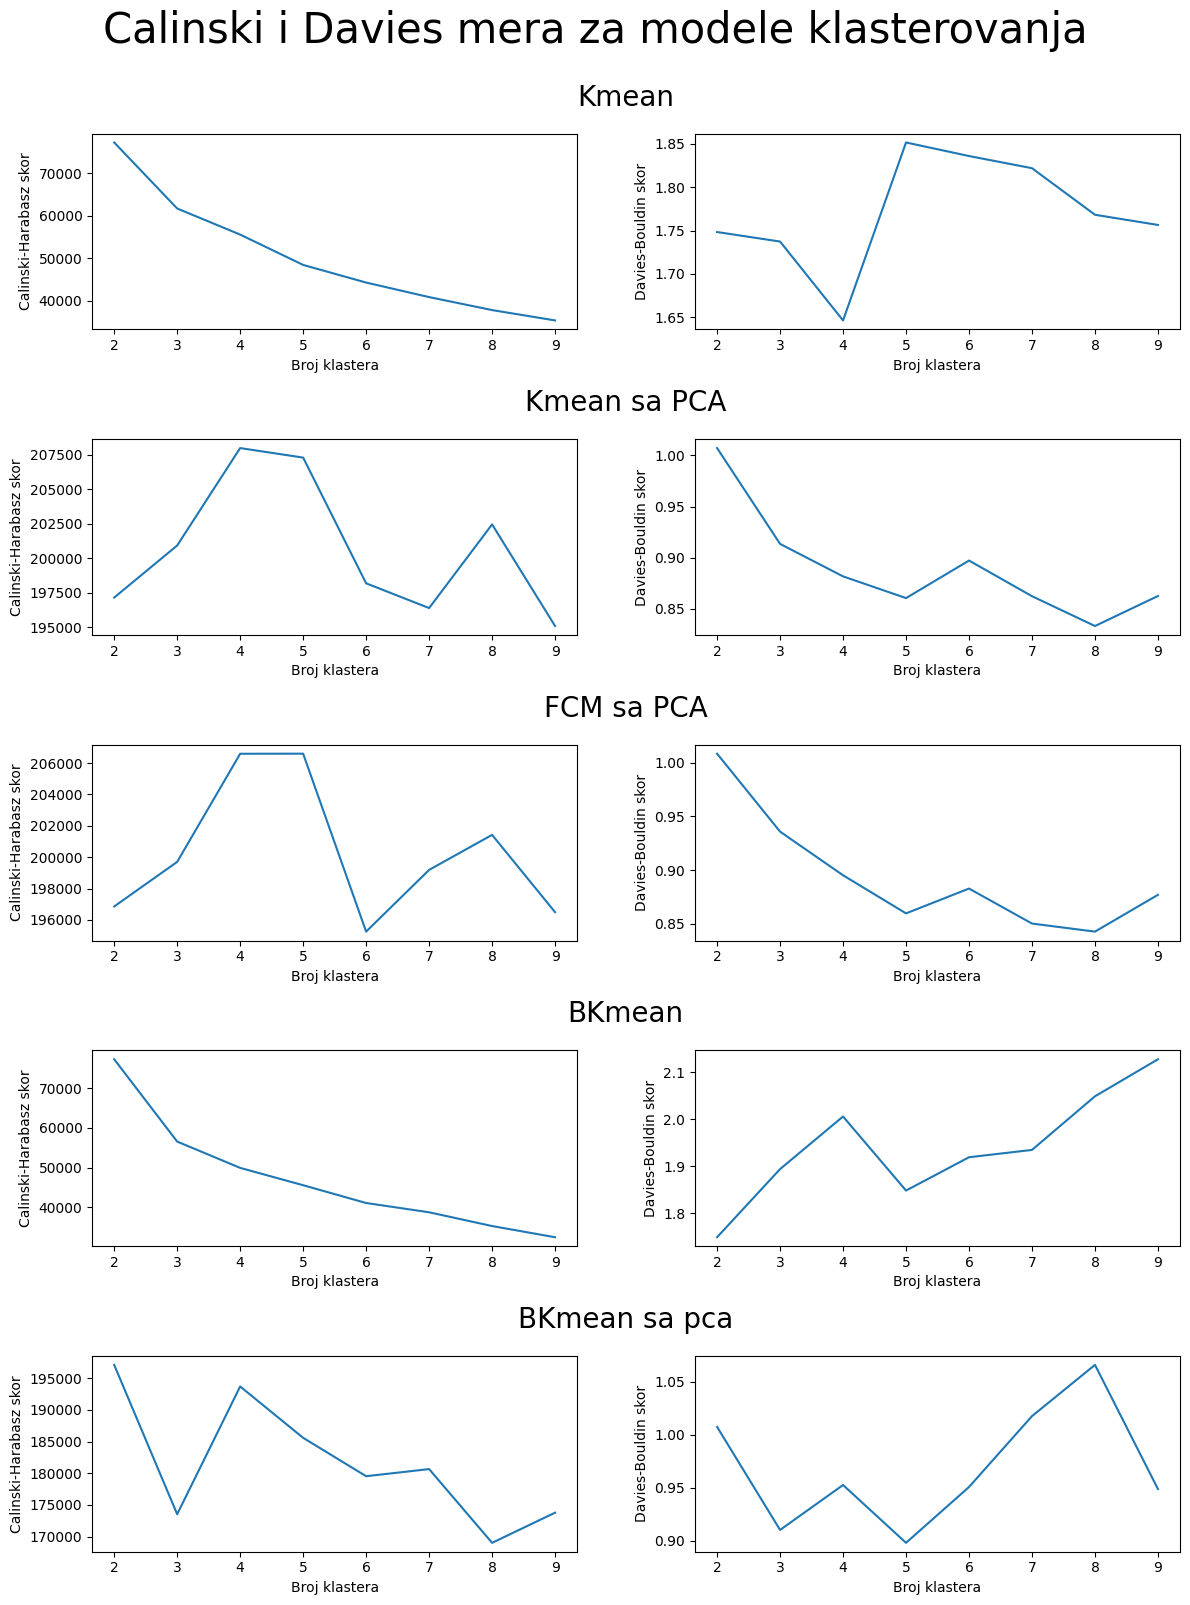

In [38]:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))
fig.suptitle("Calinski i Davies mera za modele klasterovanja", y = 1, fontsize = 30)

axs = axs.flatten()
axs[0].plot(k, Kmean_calinski)
axs[0].set_xlabel('Broj klastera')
axs[0].set_ylabel('Calinski-Harabasz skor')
axs[0].set_title("Kmean", x = 1.1, y = 1.1, size = 20)
axs[1].plot(k, Kmean_davies)
axs[1].set_xlabel('Broj klastera')
axs[1].set_ylabel('Davies-Bouldin skor')

axs[2].plot(k, Kmean_calinski_pca)
axs[2].set_xlabel('Broj klastera')
axs[2].set_ylabel('Calinski-Harabasz skor')
axs[2].set_title("Kmean sa PCA", x = 1.1, y = 1.1, size = 20)
axs[3].plot(k, Kmean_davies_pca)
axs[3].set_xlabel('Broj klastera')
axs[3].set_ylabel('Davies-Bouldin skor')

axs[4].plot(k, fcm_calinski_pca)
axs[4].set_xlabel('Broj klastera')
axs[4].set_ylabel('Calinski-Harabasz skor')
axs[4].set_title("FCM sa PCA", x = 1.1, y = 1.1, size = 20)
axs[5].plot(k, fcm_davies_pca)
axs[5].set_xlabel('Broj klastera')
axs[5].set_ylabel('Davies-Bouldin skor')

axs[6].plot(k, BKmean_calinski)
axs[6].set_xlabel('Broj klastera')
axs[6].set_ylabel('Calinski-Harabasz skor')
axs[6].set_title("BKmean", x = 1.1, y = 1.1, size = 20)
axs[7].plot(k, BKmean_davies)
axs[7].set_xlabel('Broj klastera')
axs[7].set_ylabel('Davies-Bouldin skor')

axs[8].plot(k, BKmean_calinski_pca)
axs[8].set_xlabel('Broj klastera')
axs[8].set_ylabel('Calinski-Harabasz skor')
axs[8].set_title("BKmean sa pca", x = 1.1, y = 1.1, size = 20)
axs[9].plot(k, BKmean_davies_pca)
axs[9].set_xlabel('Broj klastera')
axs[9].set_ylabel('Davies-Bouldin skor')

plt.tight_layout()
plt.show()

In [39]:
%store Kmean_calinski
%store Kmean_davies
%store Kmean_calinski_pca
%store Kmean_davies_pca
%store BKmean_calinski
%store BKmean_davies
%store BKmean_calinski_pca
%store BKmean_davies_pca
%store fcm_calinski_pca
%store fcm_davies_pca

%store sse
%store silhouettes
%store sse_pca
%store silhouettes_pca
%store sse_bisecting
%store silhouettes_bisecting
%store sse_bisecting_pca
%store silhouettes_bisecting_pca

Stored 'Kmean_calinski' (list)
Stored 'Kmean_davies' (list)
Stored 'Kmean_calinski_pca' (list)
Stored 'Kmean_davies_pca' (list)
Stored 'BKmean_calinski' (list)
Stored 'BKmean_davies' (list)
Stored 'BKmean_calinski_pca' (list)
Stored 'BKmean_davies_pca' (list)
Stored 'fcm_calinski_pca' (list)
Stored 'fcm_davies_pca' (list)
Stored 'sse' (list)
Stored 'silhouettes' (list)
Stored 'sse_pca' (list)
Stored 'silhouettes_pca' (list)
Stored 'sse_bisecting' (list)
Stored 'silhouettes_bisecting' (list)
Stored 'sse_bisecting_pca' (list)
Stored 'silhouettes_bisecting_pca' (list)
